In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
features = pd.read_csv('features.csv')
sales = pd.read_csv('sales.csv')
stores = pd.read_csv('stores.csv')

## 1- Merge some useful features into the dataset

In [3]:
sales['Year'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y').dt.year

sales['n_of_Week'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y').dt.week

sales['IsHoliday'] = sales['IsHoliday'].astype('int64')

sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,n_of_Week
0,1,1,05/02/2010,24924.50,0,2010,5
1,1,1,12/02/2010,46039.49,1,2010,6
2,1,1,19/02/2010,41595.55,0,2010,7
3,1,1,26/02/2010,19403.54,0,2010,8
4,1,1,05/03/2010,21827.90,0,2010,9


#### Stores dataset

In [4]:
#Size and type of store can be useful for predicting the number of sales, so we might as well merge them in to the dataset
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
sales = pd.merge(sales,stores[['Store','Type','Size']])

#### Features dataset

In [6]:
features['Year'] = pd.to_datetime(features['Date'], format='%d/%m/%Y').dt.year
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,2010
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,2010
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,2010
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,2010


In [7]:
#These features can also help to improve the accuracy of our model, so we merge them into the sales dataset
sales = pd.merge(sales, features[['Store','Date','Unemployment','Fuel_Price','Temperature','CPI',
                                 'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']])

sales.fillna(0, inplace=True)

sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,n_of_Week,Type,Size,Unemployment,Fuel_Price,Temperature,CPI,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
0,1,1,05/02/2010,24924.50,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,0.0,0.0,0.0,0.0,0.0
1,1,2,05/02/2010,50605.27,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,0.0,0.0,0.0,0.0,0.0
2,1,3,05/02/2010,13740.12,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,0.0,0.0,0.0,0.0,0.0
3,1,4,05/02/2010,39954.04,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,0.0,0.0,0.0,0.0,0.0
4,1,5,05/02/2010,32229.38,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,0.0,0.0,0.0,0.0,0.0


## 2- Plot weekly sales for each year

In [34]:
year_list = []

for year in sales['Year'].unique():
    sales_per_year = sales[sales['Year']==year]['Weekly_Sales'].groupby(sales['n_of_Week']).sum().reset_index()
    year_list.append(sales_per_year)

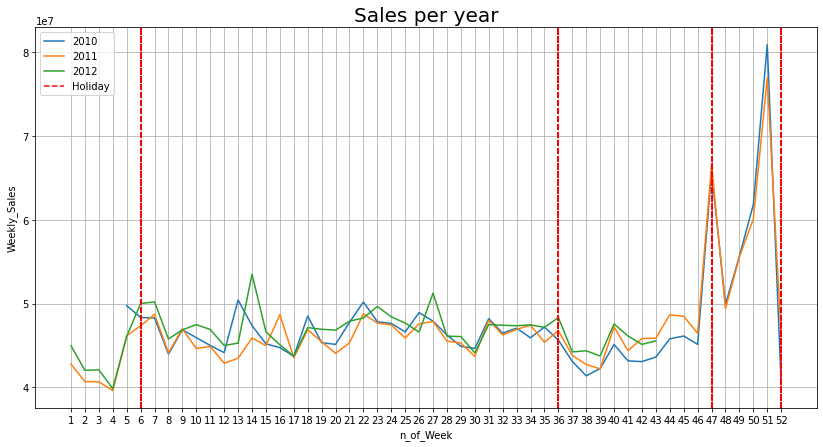

In [47]:
plt.figure(figsize=(14,7))

for i in range(len(year_list)):
    sns.lineplot(x = 'n_of_Week', y = 'Weekly_Sales', data = year_list[i])

plt.title('Sales per year', fontsize=20)
plt.grid()
plt.xticks(np.arange(1,53,1))

holiday = sales['n_of_Week'].values[(sales['IsHoliday']==1)]

for holiday_week in holiday:
    plt.axvline(holiday_week, color='red',linestyle='--')

labels = [year for year in sales['Year'].unique()]
labels.append('Holiday')

plt.legend(labels = labels)
plt.show()

## 3- Encode some columns

In [8]:
dummies_cols = pd.get_dummies(sales['Type'], prefix = 'Type')

sales.drop('Type', inplace=True, axis=1)

sales = sales.join(dummies_cols)

## 4- Predict the department-wide sales for each store for the following year

### A) Check for very negative correlations between the columns and the weekly sales

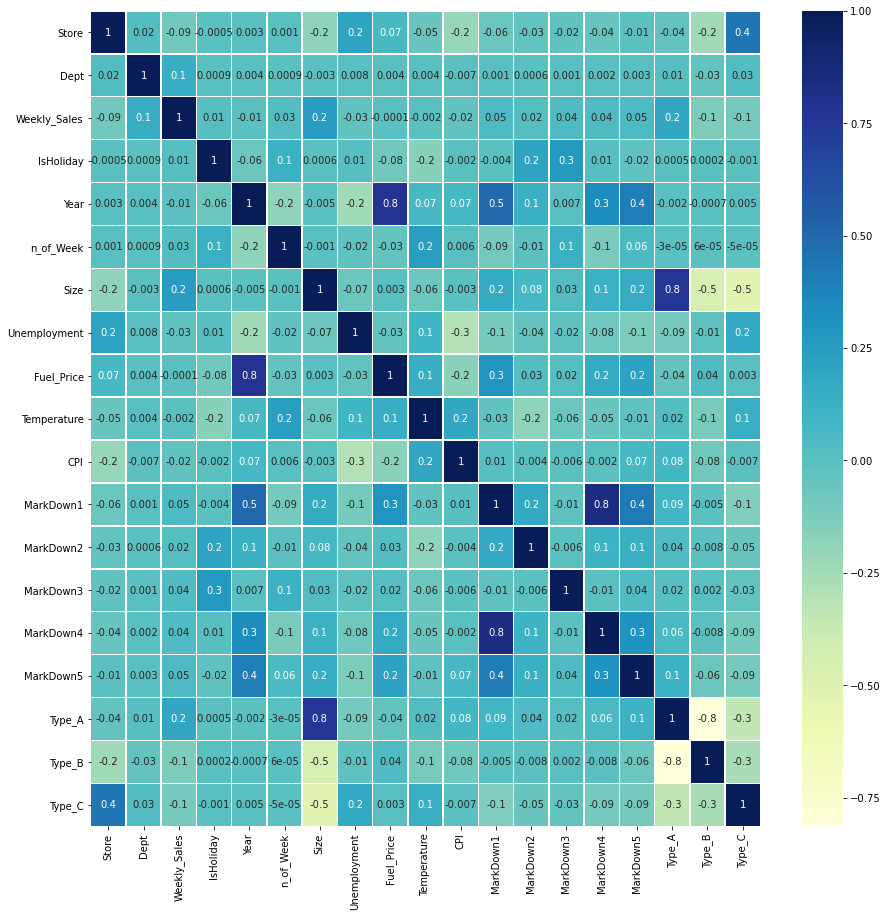

In [9]:
plt.subplots(figsize=(15,15))

sns.heatmap(sales.corr(), annot=True, fmt='.1g', linewidths=.5, cmap="YlGnBu")

### B) Split dataset into train and test

In [10]:
from sklearn.model_selection import train_test_split

y = sales['Weekly_Sales']
#We dont need the date so we drop it
x = sales.drop(['Date','Weekly_Sales'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)

### C) Create the model and evaluate it

In [11]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', XGBRegressor(n_estimators=500, n_jobs=4))
                             ])

#### XGBoost with cross-validation

In [13]:
scores = cross_val_score(my_pipeline, x, y,
                              cv=5)

print(scores.mean())

0.726166779784234
